# K-means & HLT Combined Approach
This approach for cell identification and classification combines K-means clustering with Hough Line Transform (HLT). The workflow includes the following steps:
1. read in RGB
2. threshold cholor channels by percentile (with lower bounds)
3. perform K-means clustering on thresholded image
4. subset foreground to include ONLY red and blue clusters from threshold
5. run edge detection on foreground to filter out large particles
6. convert edges to binary/custom greyscale
7. apply HLT
8. count & report infected cells

Other approaches have included Canny edge detection between steps 4 and 5 (or RH's blob removal function), and multuple line correction. Future directions will use Canny to filter the foreground mask by size (this will avoid plotting multiple lines over blobs). Some images with large particles (blobs) will overestimate the cell count, resulting in clustered cells.  

In [2]:
# Import libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.measure import label, regionprops
from skimage import filters
import skimage
import seaborn as sns
import random
import pandas as pd
import glob
import os
from math import sqrt

# Set seed for K-means clustering reproducibility
random.seed(10)

In [3]:
# FUNCTION 1: threshold_image() will read image, split channels, threshold RB channels, return thresholded image
    # input: image_path
    # output: thresholded_image, thresh_combined_mask

    # use foreground (-bg cluster) to start HLT
        # convert to binary/customgreyscale
        # run HLT


# K-means approach as a function
def threshold_image(image_path):
    '''
    This function will read in an image, split channels, threshold RB channels, 
    and return the original image, thresholded image, and threshold mask
    inputs: image_path
    outputs: image_rgb, thresholded_image, thresh_combined_mask
    '''
    # 1. Read image and convert to RGB
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Split into RGB channels for thresholding
    red_channel = image_rgb[:, :, 0]
    blue_channel = image_rgb[:, :, 2]
    
    # 2. Define thresholds for red and blue channels based on percentiles (OG R=90, B=92)
    red_threshold = np.percentile(red_channel, 90)
    blue_threshold = np.percentile(blue_channel, 92)
        # Create binary masks for each color channel
    _, red_mask = cv2.threshold(red_channel, red_threshold, 255, cv2.THRESH_BINARY)
    _, blue_mask = cv2.threshold(blue_channel, blue_threshold, 255, cv2.THRESH_BINARY)
        # Combine the red and blue masks
    combined_mask = cv2.bitwise_or(red_mask, blue_mask)
        # Apply the mask to isolate high-intensity pixels in the image
    thresholded_image = cv2.bitwise_and(image_rgb, image_rgb, mask=combined_mask)
        # VIBE IS GOOD ON THRESHOLD!
        # Make mask from new threshold for K-means clustering
    thresh_red_channel,thresh_blue_channel = thresholded_image[:, :, 0],thresholded_image[:, :, 2]
    thresh_combined_mask = cv2.bitwise_or(thresh_red_channel, thresh_blue_channel)
    #--------------
    return image_rgb, thresholded_image, thresh_combined_mask



# FUNCTION 2: cluster_foreground() takes a thresholded image and mask and returns an image with the background removed
    # input: thresholded_image, thresh_combined_mask
    # output: foreground_final

def cluster_foreground(thresholded_image, thresh_combined_mask):
    '''
    This function takes a thresholded image and mask, performs K-means clustering, parses clusters by 
    RGB characteristics, and returns an image with the background removed.
    input: thresholded_image, thresh_combined_mask
    output: foreground_final
    '''
    # 3. Perform K-means clustering
        # Flatten the masked pixels (ignore dark background)
    masked_pixels = thresholded_image[thresh_combined_mask > 0]
    pixels = masked_pixels.reshape((-1, 3)).astype(np.float32)
        # Define K-means criteria and number of clusters
    k = 4  # Number of clusters
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
        # Perform K-means clustering
    _, labels, centers = cv2.kmeans(pixels, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
        # Convert centers to uint8 for display
    centers = np.uint8(centers)
        # Reconstruct segmented data using labels
    segmented_data = centers[labels.flatten()]
        # Create an empty array to store the full-sized segmented image
    segmented_image = np.zeros_like(thresholded_image)
        # Fill in only the high-intensity pixels in the original mask
    segmented_image[thresh_combined_mask > 0] = segmented_data

    # 4. Subset mask by keeping only the clusters corresponding to red and blue
        # Automate cluster characterization based on RBG values
            # instantiate cluster values
    bg_cluster,red_cluster,blue_cluster=-1,-1,-1
        # instantiate list of color values outside loop
    max_g_val,max_r_val,max_b_val = -1,-1,-1
        # 4.1: Identify BACKGROUND cluster
            # iterate over centers (RGB values)
    for idx, cntr in enumerate(centers):
            # set green value
        g_val = cntr[1]
            # compare to max green value
        if g_val > max_g_val:
                # update max green value
            max_g_val = g_val
                # set max green value to background cluster
            bg_cluster = idx
        # 4.2: Identify RED cluster
    for idx, cntr in enumerate(centers):
            # exclude cluster previously identified as bg
        if idx != bg_cluster:
            # set red value
            r_val = cntr[0]
            # compare to max red value
            if r_val > max_r_val:
                max_r_val = r_val
                red_cluster = idx
        # 4.3: Identify BLUE cluster
    for idx, cntr in enumerate(centers):
            # exclude clusters previously identified as bg & red
        if idx != bg_cluster and idx != red_cluster:
            # set red value
            b_val = cntr[2]
            # compare to max red value
            if b_val > max_b_val:
                max_b_val = b_val
                blue_cluster = idx
    print(centers)
    print("Background cluster is", bg_cluster)
    print("Red cluster is", red_cluster)
    print("Blue cluster is", blue_cluster)
        # Reshape labels to match combined_mask shape
            # CHANGE combined_mask with thresh_combined_mask--YES?
    labels_reshaped = np.zeros(thresh_combined_mask.shape, dtype=int)
        # CHANGE TO INCLUDE thresholded_image INSTEAD OF combined_mask
    labels_reshaped[thresh_combined_mask > 0] = labels.flatten()
        # Create a mask that includes only the red and blue clusters
    foreground_mask = np.isin(labels_reshaped, [red_cluster, blue_cluster])
    # foreground_mask = np.isin(labels_reshaped, -bg_cluster)
        # Initialize the foreground image with black background
            # CHANGE to thresholded_image (where bg is actually black)--YES
    # foreground_final = np.zeros_like(image_rgb)
    foreground_final = np.zeros_like(thresholded_image)
        # Apply the mask to keep only the red and blue clusters
    foreground_final[foreground_mask] = image_rgb[foreground_mask]
    #--------------
    return foreground_final

def remove_large_background(array,window_size=30,step_size=10,max_mean=250):
    '''
    Scans across an image and removes large pixel blobs i.e. blocks where almost all pixels are filled in.
    Parameters:
    array: input 2d array of pixels (e.g. color channel)
    window_size: size of box used when calculating proportion of filled pixels.  Should be larger than desired cell width.
    step_size: movement distance between one window and the next
    max_mean: mean that pixels in a window must reach for them to be removed.
    '''
    clean_array=np.copy(array)
    for i in range(0,len(array)-window_size,step_size):
        for j in range(0,len(array[i])-window_size,step_size):    
            subset=array[i:i+window_size,j:j+window_size]
            if subset.mean()>max_mean:
                clean_array[max(i-step_size,0):min(i+window_size+step_size,len(array)-1),max(j-window_size,0):min(j+window_size+step_size,len(array[i]))]=0 #replace pixels of region passing max_mean threshold with 0
    return clean_array

# FUNCTION 3: reads in foreground image, extract channels, converts to custom greyscale for HLT
    # input: foreground_final
    # output: custom_gray
def make_custom_grayscale(foreground_final):
    '''
    Read in an image (subsetted to remove background), convert red and blue channels
    to a single grayscale array by taking the max at each coordinate. Resize image from 
    original dimensions (1388x1040) to new dimensions (160x120). Return gray image and resized image.
    input: foreground_final
    output: custom_gray, img
    '''    
    fore_red_channel,fore_blue_channel=foreground_final[:, :, 0],foreground_final[:, :, 2]
    custom_gray=[]
    # 5. Convert to custom greyscale for HLT
        # MAY dampen intensity too much..?
    for i,row in enumerate(fore_red_channel):
        custom_gray.append([])
        for j,col in enumerate(row):
            if fore_red_channel[i,j]>fore_blue_channel[i,j]:
                custom_gray[-1].append(fore_red_channel[i,j]*255)
            else:
                custom_gray[-1].append(fore_blue_channel[i,j]*255)
    custom_gray=np.array(custom_gray).astype(np.uint8)
    # make smaller image copies for hough line detection
    backup=np.copy(foreground_final)
    image=cv2.resize(backup,(160,120))
    img = np.copy(cv2.resize(custom_gray,(160,120)))
    img=img*255
    # CHANGED
    # edges = cv2.resize(custom_gray,(160,120))
    return custom_gray, img

def remove_overlapping_lines(lines,slope_threshold=0.2,distance_threshold=4):
    '''
    Removes very similar/redundant lines produced by hough line transformation.
    For an array of line coordinates, finds pairs of lines with start or end points within distance_threshold of each otehr and slopes within slope_threshold of each other, then removes the shorter line.
    '''
    line_slopes=[]
    for line in lines:
        # subtract inital x/y from second x/y and divide to get slope
            # IS THIS WHERE IT'S ADJUSTING THE SLOPE?
                # ALSO NEED TO SET A LENGTH LIMIT
        line_slopes.append((line[3]-line[1])/(line[2]-line[0])) 
    
    indices_to_remove=[]
    for i,slope1 in enumerate(line_slopes):
        for j,slope2 in enumerate(line_slopes):
            if i<j:
                # WHAT IS THE VALUE/MEANING OF A SLOPE THRESHOLD?
                if abs(slope2-slope1)<=slope_threshold: #examine pairs of lines with slopes within slope threshold
                    line1,line2=lines[i],lines[j]
                    x11,y11,x12,y12=line1 #first x coordinate, first y coordinate, second x coordinate, second y coordinate of line 1
                    x21,y21,x22,y22=line2 #first x coordinate, first y coordinate, second x coordinate, second y coordinate of line 2
                    #if (abs(x11-x21)<=distance_threshold and abs(y11-y21)<=distance_threshold) or (abs(x11-x22)<=distance_threshold and abs(y11-y22)<=distance_threshold) or (abs(x12-x21)<=distance_threshold and abs(y12-y21)<=distance_threshold) or (abs(x12-x22)<=distance_threshold and abs(y12-y22)<=distance_threshold):
                    if (sqrt((x11-x21)**2+(y11-y21)**2)<=distance_threshold) or (sqrt((x11-x22)**2+(y11-y22)**2)<=distance_threshold) or (sqrt((x12-x21)**2+(y12-y21)**2)<=distance_threshold) or (sqrt((x12-x22)**2+(y12-y22)**2)<=distance_threshold):
                        #Keep longer line:
                            # I'M SUSPICIOUS OF THIS ASSUMPTION
                        if sqrt((x11-x12)**2 + (y11-y12)**2) > sqrt((x21-x22)**2 + (y21-y22)**2):
                            indices_to_remove.append(j)
                        else:
                            indices_to_remove.append(i)
    new_lines=[]
    #image=cv2.resize(backup,(x_size, y_size))
    for i,line in enumerate(lines):
        if i not in indices_to_remove:
            x1,y1,x2,y2=line
            new_lines.append(line)
            #cv2.line(image,(x1,y1),(x2,y2),(np.random.randint(50,255),np.random.randint(50,255),np.random.randint(50,255)),2)
    #plt.imshow(image)
    print(f"Removed {len(set(indices_to_remove))} very similar lines.")
    return new_lines



Processing GoodEarlySilica_AS_A_I_15_6_20240717.jpg
[[ 48   0 130]
 [ 55   0 221]
 [231 222 234]
 [ 82   0  68]]
Background cluster is 2
Red cluster is 3
Blue cluster is 1
I counted 25 cells.
Infection proportions are being calculated...
Image processing complete.

Individual Cell Blue:Red Ratios
    Cell Number  Red Intensity Sum  Blue Intensity Sum  Blue:Red Ratio  \
0             0             366898              305727        0.833275   
1             1             652351              518123        0.794240   
2             2             435194              412439        0.947713   
3             3             546848              366830        0.670808   
4             4             428239              318375        0.743452   
5             5             513491              338209        0.658646   
6             6             391668              393695        1.005175   
7             7             420980              274375        0.651753   
8             8             363039 

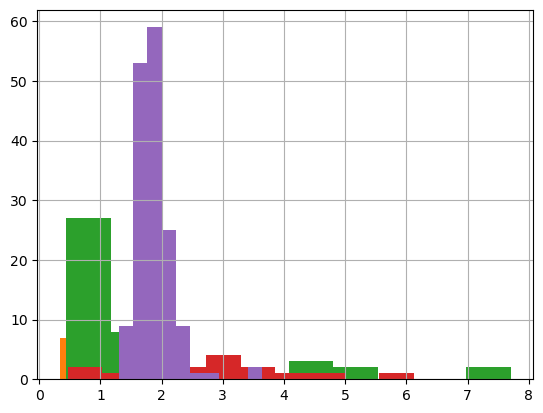

In [5]:
# no new function, just call all things and run HLT in-line
    # loop through testing images
    # call threshold_image()
    # call cluster_foreground()
    # call make_custom_grayscale()
    # call cv2.HoughLinesP()
    # reset color channels from image_rgb (threshold_image() output)
    # draw lines on image
    # setup classification paradigm
    # calculate ratios
    # write jpgs & csvs

# Define vars
x_size,y_size=160,120
original_x_size,original_y_size=1388,1040 #initial size of input images

# Process all images in a folder

image_folder = "../data/images/" # GitHub WD
# image_folder = "../data/test_images/" # GitHub WD
csv_folder = "../figures/Combined_classification/data/" # GitHub WD
csv_folder = "../figures/Combined_classification/classified/" # GitHub WD
    # smaller testing set
# image_folder = "../images/" # local WD
    # larger testing set
# image_folder = "../images/raw/" # local WD
# csv_folder = "../figures/Combined_classification/subset/data/"
# jpg_folder = "../figures/Combined_classification/subset/classified" # local WD

image_paths = glob.glob(os.path.join(image_folder, "*.jpg"))

# WARNING: running this saves a lot of csv and jpg files locally
    # loop through testing images
for image_path in image_paths:
    print("")
    print(f"Processing {os.path.basename(image_path)}")
    # call threshold_image()
    image_rgb, thresholded_image, thresh_combined_mask = threshold_image(image_path)
    # reset color channels from image_rgb (threshold_image() output)
    red_channel,blue_channel=image_rgb[:, :, 0],image_rgb[:, :, 2]
    # remove conglomerate pixels (positive results!!)
    red_channel=remove_large_background(red_channel,50,10,250)
    blue_channel=remove_large_background(blue_channel,50,10,250)
    # call cluster_foreground()
    foreground_final = cluster_foreground(thresholded_image, thresh_combined_mask)
    # set thresholded color channels
    fore_red_channel,fore_blue_channel=foreground_final[:, :, 0],foreground_final[:, :, 2]
    # call make_custom_grayscale()
        # CHANGED: return foreground_mask..?
    custom_gray, img = make_custom_grayscale(foreground_final)
    # call cv2.HoughLinesP()    
    lines = list([list(val[0]) for val in cv2.HoughLinesP(
            cv2.resize(custom_gray,(x_size,y_size)), # Input edge image
            1, # Distance resolution in pixels
            np.pi/180, # Angle resolution in radians
            # TRY MAKING THRESHOLD VOTES LOWER (OG was 22)-[10 was too many fp]
            threshold=20, # Min number of votes for valid line - lower values will give higher detection rate but also result in more-double counting
            # MAKE LEN LOWER (OG WAS 20)
            minLineLength=20, # Min allowed length of line - in practice I haven't found changing this parameter either way to help much
            maxLineGap=5 # Max allowed gap between line for joining them - lower values with result in better detection rate of spotty cells, but also higher probability that background noise will be misclassified as a cell
            )])
    
    # remove lines with similar slopes
    # lines=remove_overlapping_lines(lines)
    
    # make list of all coordinates
    all_coordinates=[]
    # original_y_size, original_x_size before in place of numbers, in this order...
    img=np.zeros((1388,1040),np.uint8)
    print(f"I counted {len(lines)} cells.")
    print("Infection proportions are being calculated...")
    # Define df for csv export
    cell_ratios = []
    total_cells = len(lines)
    # may not need this bc adding it to cell_ratio below
    # proportion_infected=[]
    annotated_image=np.copy(image_rgb)

    #iterate through lines, calculate infection proportion of each cell and annotate the original image with a line and cell number
    for cell_number,line in enumerate(lines):
        temp_red=fore_red_channel.copy()
        temp_blue=fore_blue_channel.copy()

        #convert coordinates to size of initial image, pre-downsizing
        x1,y1,x2,y2=int(line[0]*original_y_size/y_size),int(line[1]*original_x_size/x_size),int(line[2]*original_y_size/y_size),int(line[3]*original_x_size/x_size)
        img=np.zeros((original_y_size, original_x_size),np.uint8)
        cv2.line(img,(x1,y1),(x2,y2),255,20)
        coords = np.argwhere(img) #returns coordinates of all non-zero pixels i.e. where the line/cell is
        all_coordinates.append([f"{val[0]}_{val[1]}" for val in coords])

        #get an array with pixels filled just at the location of the line, in order to calculate infection proportion
        #Q: this uses the binary (0/255) pixel values- would the original continuous values be more meaningful?
        subsetted_rgb=image_rgb.copy()
        # temp_red=red_channel.copy()
        # temp_blue=blue_channel.copy()
        target_coordinates={val:"" for val in all_coordinates[cell_number]}
        for i,row in enumerate(temp_red):
                for j,val in enumerate(row):
                    # set all non-red pixels to 0
                    if f"{i}_{j}" not in target_coordinates.keys():
                        temp_red[i][j]=0
                        temp_blue[i][j]=0
                        subsetted_rgb[i][j][0]=0
                        subsetted_rgb[i][j][1]=0
                        subsetted_rgb[i][j][2]=0
        # Calculate blue:red ratio for this cell
        red_sum = np.sum(temp_red)
        blue_sum = np.sum(temp_blue)
        blue_red_ratio = blue_sum / red_sum if red_sum > 0 else 0  # Avoid division by zero
        proportion_infected = blue_sum / (blue_sum + red_sum) if (blue_sum + red_sum) > 0 else 0
        # add to df for csv export
        cell_ratios.append({
            'Cell Number': cell_number,
            'Red Intensity Sum': red_sum,
            'Blue Intensity Sum': blue_sum,
            'Blue:Red Ratio': blue_red_ratio,
            'Proportion Infected': proportion_infected
        })        
        # proportion_infected.append(np.sum(temp_blue)/(np.sum(temp_red)+np.sum(temp_blue)))
        is_infected=False if proportion_infected<0.2 else True
        # is_infected=False if cell_ratios[4][-1] <0.2 else True
        # is_infected=False if cell_ratios.at['Proportion Infected', -1] <0.2 else True
        # is_infected=False if proportion_infected[-1]<0.2 else True
        # Annotate image
            # draw lines on image
        cv2.line(annotated_image,(x1,y1),(x2,y2),(255,255,255),20) #white line
        if is_infected:
            number_color=(150, 150, 255)
        else:
            number_color=(255,150,150)
        cv2.putText(
            annotated_image, 
            str(cell_number),  # Label with cell number
            (x1,y1),  
            cv2.FONT_HERSHEY_SIMPLEX, 
            2,  # Font size
            number_color,  # White text
            4  # Thickness
        )
    # print(cell_ratios)
    # print(f"I counted {len([val for val in proportion_infected if val>=0.2])} infected and {len([val for val in proportion_infected if val<0.2])} uninfected cells.")
    print("Image processing complete.")

    # 8. Convert ratios to DataFrame for easy viewing
    cell_ratios_df = pd.DataFrame(cell_ratios)
        # Calculate & report image overall blue:red ratio
            # CHANGED from foreground_mask to thresh_combined_mask
    total_red = np.sum(red_channel[thresh_combined_mask])
            # CHANGED from foreground_mask to thresh_combined_mask
    total_blue = np.sum(blue_channel[thresh_combined_mask])
    overall_blue_red_ratio = total_blue / total_red if total_red > 0 else 0
        # Display results
    print("\nIndividual Cell Blue:Red Ratios")
    print(cell_ratios_df)
    print(f"\nTotal Cells: {total_cells}")
    print(f"Overall Blue:Red Ratio in Image: {overall_blue_red_ratio:.2f}")
    
    # Generate basename
    base_filename = os.path.splitext(os.path.basename(image_path))[0]
    # Generate .csv output filename based on the input image name
    csv_output_path = os.path.join(csv_folder, f"{base_filename}.csv")
    image_output_path = os.path.join(jpg_folder, f"{base_filename}_labeled.jpg")
    
    # Save the dataframe to a CSV file
    cell_ratios_df.to_csv(csv_output_path, index=False)
    # Save the image to a JPG file
    print(f"Saved results to {csv_output_path}")
    # Save the labeled image to a JPG file
    cv2.imwrite(image_output_path, cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))  # Convert back to BGR for saving
    print(f"Saved labeled image to {image_output_path}")
    cell_ratios_df['Blue:Red Ratio'].hist()

    #uncomment below to get inline images
    '''
    fig, ax = plt.subplots(1, 4, figsize=(13, 10))
    ax[0].imshow(image_rgb, cmap='magma')
    ax[1].imshow(custom_gray, cmap='magma')
    ax[2].imshow(thresholded_image, cmap='magma')
    ax[3].imshow(annotated_image, cmap='magma')
        # set the title to all subplots
    ax[0].set_title("Original Image")
    ax[1].set_title("Custom Grayscale Image")
    ax[2].set_title("Thresholded Image")
    ax[3].set_title("Annotated Image")
    # ax[3].set_title(f"{len([val for val in proportion_infected if val>=infection_threshold])} infected, {len([val for val in proportion_infected if val<infection_threshold])} uninfected")
    fig.tight_layout()
    '''



In [ ]:
# check blue"red ratios for infection populations
# cell_ratios_df['Blue:Red Ratio'].hist()
# real dataset
# /Users/kjehickman/Documents/Research/parasites/E3/data/micrographs